### Import of the relevant libraries for the whole exercise

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
!conda install -c conda-forge folium=0.5.0 --yes
import folium
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be 

### Step 1 - Building of the dataframe 

Use of BeautifulSoup to retrieve all tables of the Wikipedia page

In [2]:
r= requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(r.text, 'html.parser')
tables = [
    [
        [td.get_text(strip=True) for td in tr.find_all('td')] 
        for tr in table.find_all('tr')
    ] 
    for table in soup.find_all('table')
]

Selection of the 1st table corresponding to the required table

In [3]:
requiredtable = tables[0]

Transformation of the table into a pandas dataframe with renaming of columns and deletion of the 1st blank row

In [4]:
neighborhoods = pd.DataFrame(requiredtable, columns=['Postcode', 'Borough', 'Neighborhood'])
neighborhoods.drop(neighborhoods.index[0],inplace=True)

Filtering of the dataframe to ignore cells with a borough that is Not assigned

In [5]:
neighborhoods = neighborhoods[neighborhoods['Borough'] != 'Not assigned']

Combining Neighborhoods into one row that have the same Postcode & Borough 

In [6]:
neighborhoods = neighborhoods.sort_values(['Postcode','Borough','Neighborhood'])
neighborhoods = neighborhoods.groupby(['Postcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()

If a cell has a Borough but a "Not assigned" Neighborhood, then the Neighborhood will be the same as the Borough.

In [7]:
neighborhoods.Neighborhood.replace("Not assigned",neighborhoods.Borough,inplace=True)

Number of rows of the final dataframe

In [8]:
neighborhoods.shape

(103, 3)

In [9]:
neighborhoods.head()

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Step 2 - Retrieval of the latitude and the longitude coordinates of each neighborhood (as geocoder is not working, import of the CSV file)

In [10]:
neighborhoods_geo = pd.read_csv("http://cocl.us/Geospatial_data")
neighborhoods_geo.rename(columns={'Postal Code': 'Postcode'},inplace = True) 
neighborhoods_geo.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
neighborhoods = neighborhoods.join(neighborhoods_geo.set_index('Postcode'), on='Postcode')
neighborhoods.head(10)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [12]:
print('The dataframe has {} boroughs and {} groups of neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 11 boroughs and 103 groups of neighborhoods.


Use of the geopy library to get the latitude and longitude values of Toronto

In [13]:
address = 'Toronto, ON'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronta are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronta are 43.653963, -79.387207.


Creation of a map of Toronto with neighborhoods superimposed on top.

In [14]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Step 3.1 - Clustering - Exploration of neighborhoods in Toronto 

I decided to explore and to cluster all neighborhoods in Toronto.

Definition of Foursquare Credentials and Version

In [15]:
# The code was removed by Watson Studio for sharing.

Creation of a function to explore all neighborhoods in Toronto (with top 100 venues and a radius of 500 meters)

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            500, 
            100)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

Run of the above function on each neighborhood and creation of a new dataframe called toronto_venues

In [17]:
toronto_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Check of the size of the resulting dataframe

In [18]:
print(toronto_venues.shape)
toronto_venues.head()

(2255, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [19]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 274 uniques categories.


Analyzis of each neighborhood (with one hot encoding)

In [20]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
toronto_onehot.shape

(2255, 274)

Group of rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [22]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.020000,0.000000,0.00,0.000000,0.000000,0.010000,0.0,0.000000,0.0
1,Agincourt,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0
4,"Alderwood, Long Branch",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0
5,"Bathurst Manor, Downsview North, Wilson Heights",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.05,0.000000,0.000000,0.000000,0.0,0.000000,0.0
6,"Bathurst Quay, CN Tower, Harbourfront West, Is...",0.000000,0.0,0.000000,0.066667,0.066667,0.066667,0.066667,0.2,0.133333,...,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0
7,Bayview Village,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0
8,"Bedford Park, Lawrence Manor East",0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0
9,Berczy Park,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.017544,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.0


Confirmation of the new size

In [23]:
toronto_grouped.shape

(100, 274)

Creation of a function to sort the venues in descending order

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

Creation of a new dataframe and display of the top 10 venues for each neighborhood

In [25]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']
for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Burger Joint,Cosmetics Shop,Hotel,American Restaurant,Restaurant,Thai Restaurant
1,Agincourt,Lounge,Sandwich Place,Breakfast Spot,Skating Rink,Chinese Restaurant,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Park,Women's Store,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Fried Chicken Joint,Pharmacy,Pizza Place,Fast Food Restaurant,Coffee Shop,Beer Store,Sandwich Place,Women's Store,Dog Run
4,"Alderwood, Long Branch",Pizza Place,Pub,Coffee Shop,Gym,Pharmacy,Sandwich Place,Skating Rink,Pool,Women's Store,Department Store


In [26]:
neighborhoods_venues_sorted.shape

(100, 11)

### Step 3.2 - Clustering - Clustering of the neighborhoods of Toronto¶

Use of the Elbow method to determine the best k paramater for Kmeans

In [27]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

In [28]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,20) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(toronto_grouped_clustering) 
    kmeanModel.fit(toronto_grouped_clustering)     
      
    distortions.append(sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / toronto_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / toronto_grouped_clustering.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

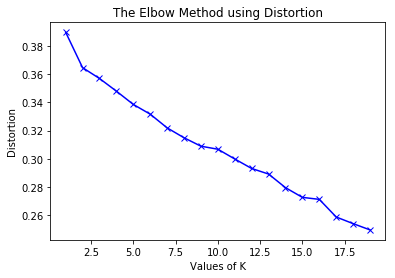

In [29]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

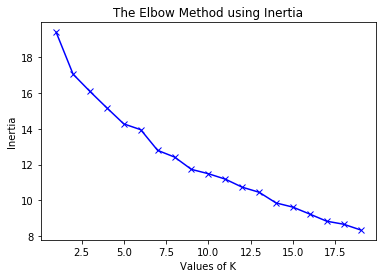

In [30]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

Run of k-means to cluster the neighborhood into 5 clusters

In [31]:
kclusters = 5
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[0:10] 

array([1, 2, 0, 2, 2, 1, 1, 1, 1, 1], dtype=int32)

Creation of a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [32]:
neighborhoods_venues_sorted.dtypes

Neighborhood              object
1st Most Common Venue     object
2nd Most Common Venue     object
3rd Most Common Venue     object
4th Most Common Venue     object
5th Most Common Venue     object
6th Most Common Venue     object
7th Most Common Venue     object
8th Most Common Venue     object
9th Most Common Venue     object
10th Most Common Venue    object
dtype: object

In [33]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [34]:
neighborhoods_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Steakhouse,Burger Joint,Cosmetics Shop,Hotel,American Restaurant,Restaurant,Thai Restaurant
1,2,Agincourt,Lounge,Sandwich Place,Breakfast Spot,Skating Rink,Chinese Restaurant,Donut Shop,Diner,Discount Store,Dog Run,Doner Restaurant
2,0,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Park,Women's Store,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
3,2,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Fried Chicken Joint,Pharmacy,Pizza Place,Fast Food Restaurant,Coffee Shop,Beer Store,Sandwich Place,Women's Store,Dog Run
4,2,"Alderwood, Long Branch",Pizza Place,Pub,Coffee Shop,Gym,Pharmacy,Sandwich Place,Skating Rink,Pool,Women's Store,Department Store
5,1,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Grocery Store,Frozen Yogurt Shop,Shopping Mall,Bridal Shop,Sandwich Place,Fast Food Restaurant,Diner,Restaurant,Bank
6,1,"Bathurst Quay, CN Tower, Harbourfront West, Is...",Airport Service,Airport Terminal,Boat or Ferry,Airport Lounge,Coffee Shop,Sculpture Garden,Bar,Harbor / Marina,Airport Gate,Airport Food Court
7,1,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Dim Sum Restaurant,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
8,1,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Sushi Restaurant,Grocery Store,Indian Restaurant,Fast Food Restaurant,Juice Bar,Liquor Store,Comfort Food Restaurant,Pharmacy
9,1,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Steakhouse,Beer Bar,Cheese Shop,Farmers Market,Bakery,Café,Diner


In [35]:
toronto_merged = neighborhoods
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,2.0,Fast Food Restaurant,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Harbor / Marina
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497,4.0,Bar,Women's Store,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Fast Food Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1.0,Medical Center,Electronics Store,Pizza Place,Intersection,Breakfast Spot,Rental Car Location,Mexican Restaurant,Doner Restaurant,Diner,Discount Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,Coffee Shop,Korean Restaurant,Women's Store,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1.0,Hakka Restaurant,Bank,Athletics & Sports,Bakery,Thai Restaurant,Caribbean Restaurant,Fried Chicken Joint,Eastern European Restaurant,Dumpling Restaurant,Drugstore


Check of the types of the dataframe

In [36]:
toronto_merged.dtypes

Postcode                   object
Borough                    object
Neighborhood               object
Latitude                  float64
Longitude                 float64
Cluster Labels            float64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

Cluster labels should be int - Check if there are missing data

In [37]:
missing_data = toronto_merged.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

Postcode
False    103
Name: Postcode, dtype: int64

Borough
False    103
Name: Borough, dtype: int64

Neighborhood
False    103
Name: Neighborhood, dtype: int64

Latitude
False    103
Name: Latitude, dtype: int64

Longitude
False    103
Name: Longitude, dtype: int64

Cluster Labels
False    100
True       3
Name: Cluster Labels, dtype: int64

1st Most Common Venue
False    100
True       3
Name: 1st Most Common Venue, dtype: int64

2nd Most Common Venue
False    100
True       3
Name: 2nd Most Common Venue, dtype: int64

3rd Most Common Venue
False    100
True       3
Name: 3rd Most Common Venue, dtype: int64

4th Most Common Venue
False    100
True       3
Name: 4th Most Common Venue, dtype: int64

5th Most Common Venue
False    100
True       3
Name: 5th Most Common Venue, dtype: int64

6th Most Common Venue
False    100
True       3
Name: 6th Most Common Venue, dtype: int64

7th Most Common Venue
False    100
True       3
Name: 7th Most Common Venue, dtype: int64

8th Most Common Ve

There are 3 rows with missing data. Deletion of those rows.

In [38]:
toronto_merged = toronto_merged.dropna()

Change of the type of "Cluster Labels" to int

In [39]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int) 
toronto_merged.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,2,Fast Food Restaurant,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Harbor / Marina
1,M1C,Scarborough,"Highland Creek, Port Union, Rouge Hill",43.784535,-79.160497,4,Bar,Women's Store,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Fast Food Restaurant
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1,Medical Center,Electronics Store,Pizza Place,Intersection,Breakfast Spot,Rental Car Location,Mexican Restaurant,Doner Restaurant,Diner,Discount Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Coffee Shop,Korean Restaurant,Women's Store,Dumpling Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Hakka Restaurant,Bank,Athletics & Sports,Bakery,Thai Restaurant,Caribbean Restaurant,Fried Chicken Joint,Eastern European Restaurant,Dumpling Restaurant,Drugstore


Creation of the map with the clusters

In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)       
map_clusters